In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install rouge

In [22]:
import pandas as pd
import re
import numpy as np
from pprint import pprint
import evaluate
import time
from rouge import Rouge
import random
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import string

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
# read review file
review_path = '/content/drive/MyDrive/W266 Final Project/manual_summarization.csv'
manual_review = pd.read_csv(review_path, header=0)
manual_review.columns = ['assigned_to', 'business_id', 'word_count', 'text_top10', 'chatGPT_summary']
manual_review = manual_review[['business_id', 'chatGPT_summary']]
manual_review.head(5)

,business_id,chatGPT_summary
0,hHzKMfJe7uuw_7WIEHEwBQ,The reviewers had a mixed experience at PJs oy...
1,49dVbKxmhJ08KGH--9getA,The reviewers had a mixed experience at Ramen ...
2,WNqqyUtEmrqCBEHNV9sj5Q,Marcellos in Bordentown offers a great Main St...
3,V66EXhrxKanesMhoOqsORw,Shorty's Sunflower Cafe is a delightful find i...
4,YVvm1Q3ir5TET0f66FOX_g,"La Terrazza is a hidden gem in Tampa, offering..."


In [24]:
# read BART grid search file
bart_path = '/content/drive/MyDrive/W266 Final Project/BART_gridsearch_2.csv'
bart_summary = pd.read_csv(bart_path, header=0)
bart_summary.shape

(900, 7)

In [25]:
# read SpaCy summary
spacy_path = '/content/drive/MyDrive/W266 Final Project/spacy_summary.csv'
spacy_summary = pd.read_csv(spacy_path, header=0)
spacy_summary = spacy_summary[['business_id', 'spacy_summary']]
spacy_summary.shape

(10318, 2)

In [26]:
# read TextRank summary
textrank_path = '/content/drive/MyDrive/W266 Final Project/textrank_summary.csv'
textrank_summary = pd.read_csv(textrank_path, header=0)
textrank_summary = textrank_summary[['business_id', 'textrank_summary']]
textrank_summary.shape

(10318, 2)

In [29]:
# join manual_review and bart_summary
joined = pd.merge(bart_summary, manual_review, how='left', on='business_id')


In [30]:
# combine spacy and textrank summaries to create an extractive summary df
spacy_joined = pd.merge(manual_review, spacy_summary, how='left', on='business_id').rename(columns={'spacy_summary':'summary'})
spacy_joined['method'] = 'spaCy'
#textrank_joined = pd.merge(manual_review, textrank_summary, how='left', on='business_id')
textrank_joined = pd.merge(manual_review, textrank_summary, how='left', on='business_id').rename(columns={'textrank_summary':'summary'})
textrank_joined['method'] = 'TextRank'
extractive_joined = spacy_joined.append(textrank_joined)
#extractive_joined = pd.merge(spacy_joined, textrank_summary, how='left', on='business_id')
extractive_joined.shape

<ipython-input-30-e6f22cfe38cb>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extractive_joined = spacy_joined.append(textrank_joined)


(208, 4)

In [31]:
# Preprocessing function
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    return ' '.join(tokens)

# Apply preprocessing to 'chatGPT_summary' and 'bart_summary'
joined['chatGPT_summary'] = joined['chatGPT_summary'].apply(preprocess)
joined['bart_summary'] = joined['bart_summary'].apply(preprocess)

# apply preprocessing to 'summary' of extractive summaries
extractive_joined['chatGPT_summary'] = extractive_joined['chatGPT_summary'].apply(preprocess)
extractive_joined['summary'] = extractive_joined['summary'].apply(preprocess)

In [32]:
def calculate_rouge(joined, summary_col):
  # Initialize the Rouge scorer
  rouge = Rouge()

  # Calculate ROUGE scores
  rouge_scores = joined.apply(lambda row: rouge.get_scores(row[summary_col], row['chatGPT_summary'])[0], axis=1)

  # Create separate columns for each ROUGE score
  joined['rouge-1'] = rouge_scores.apply(lambda x: x['rouge-1']['f'])
  joined['rouge-2'] = rouge_scores.apply(lambda x: x['rouge-2']['f'])
  joined['rouge-l'] = rouge_scores.apply(lambda x: x['rouge-l']['f'])

  return joined

In [33]:
def calculate_bleu(joined, summary_col):
  bleu_scores = []

  for index, row in joined.iterrows():
      reference = row['chatGPT_summary']
      candidate = row[summary_col]

      reference_tokens = word_tokenize(preprocess(reference))
      candidate_tokens = word_tokenize(preprocess(candidate))

      # Calculate BLEU score for a single sentence
      bleu = sentence_bleu([reference_tokens], candidate_tokens)
      bleu_scores.append(bleu)

  # Add BLEU scores to the DataFrame
  joined['bleu'] = bleu_scores

  return joined

In [36]:
def aggregate_BART_rouge(joined):
  # summarize distribution in a chart
  rouge_summary = joined.groupby(['beam_size', 'no_repeat_ngrams']).agg({
      'rouge-1': ['mean', 'median'],
      'rouge-2': ['mean', 'median'],
      'rouge-l': ['mean', 'median']
  }).reset_index()
  rouge_summary = rouge_summary.round(4)

  return rouge_summary

def aggregate_rouge(joined):
  # summarize distribution in a chart
  rouge_summary = joined.groupby('method').agg({
      'rouge-1': ['mean', 'median'],
      'rouge-2': ['mean', 'median'],
      'rouge-l': ['mean', 'median']
  }).reset_index()
  rouge_summary = rouge_summary.round(4)

  return rouge_summary

In [45]:
# distribution of rouge scores for each beam_size, no_repeat_ngrams
def plot_rouge_scores(df, rouge_type):

  # Define colors based on no_repeat_ngrams values
  color_dict = {3: 'blue', 5: 'red', 7: 'green'}

  # Create scatter plot for each beam_size
  plt.figure(figsize=(8, 8))
  for beam_size in df['beam_size'].unique():
      subset = df[df['beam_size'] == beam_size]
      for idx, row in subset.iterrows():
          x = beam_size + random.uniform(-0.1, 0.1)
          y = row[rouge_type] + random.uniform(-0.1, 0.1)  # Add jitter to y-coordinate
          plt.scatter(x, y, c=color_dict[row['no_repeat_ngrams']], label=f'Beam Size {beam_size}', s=50)


  # Set custom legend labels with no_repeat_ngrams
  handles = []
  for ngram_value, color_value in color_dict.items():
      handles.append(plt.Line2D([], [], marker='o', markersize=10, color=color_value, label=f'no_repeat_ngrams={ngram_value}'))

  plt.title('Scatter Plot of ROUGE-1 Scores by num_beams and no_repeat_ngram_size')
  plt.xlabel('Num Beams')
  plt.ylabel(f'{rouge_type} Score')
  plt.xticks([1, 3, 5])  # Show only specific tick marks
  plt.legend(handles=handles)
  plt.grid(True)
  plt.show()

In [18]:
# rouge scores for BART summaries
BART_rouge = calculate_rouge(joined, 'bart_summary')
aggregate_BART_rouge(BART_rouge).head()

beam_size no_repeat_ngrams rouge-1         rouge-2         rouge-l        
                                mean  median    mean  median    mean  median
0         1                3  0.2413  0.2374  0.0778  0.0653  0.1641  0.1579
1         1                5  0.2353  0.2405  0.0738  0.0644  0.1657  0.1605
2         1                7  0.2342  0.2244  0.0737  0.0656  0.1669  0.1649
3         3                3  0.2374  0.2334  0.0602  0.0546  0.1673  0.1561
4         3                5  0.2342  0.2241  0.0586  0.0553  0.1661  0.1562

In [20]:
# rouge scores for SpaCy summaries
extractive_rouge = calculate_rouge(extractive_joined, 'summary')
aggregate_rouge(extractive_rouge)

method rouge-1         rouge-2        rouge-l        
               mean  median    mean median    mean  median
0  TextRank  0.0782  0.0690  0.0068   0.00  0.0583  0.0551
1     spaCy  0.2220  0.2224  0.0452   0.04  0.1302  0.1225

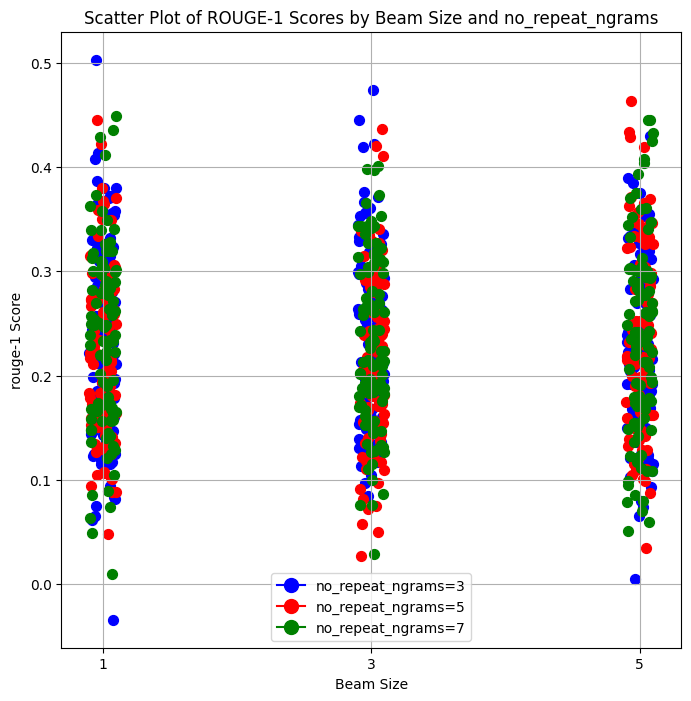

In [43]:
plot_rouge_scores(BART_rouge, 'rouge-1')

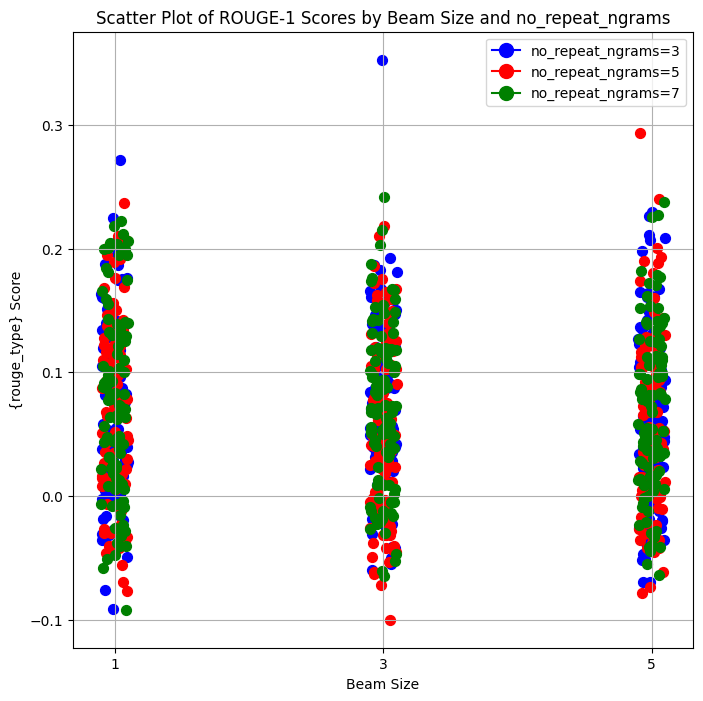

In [39]:
plot_rouge_scores(BART_rouge, 'rouge-2')

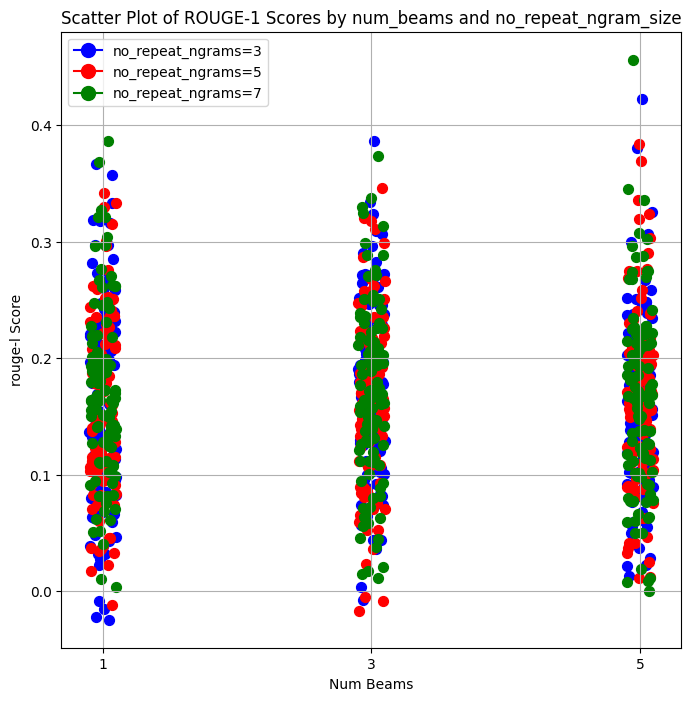

In [46]:
plot_rouge_scores(BART_rouge, 'rouge-l')